# Libraries

In [1]:
import os, random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split 

from tensorflow.keras.applications import EfficientNetB3

# Variables and Hyperparameters

In [2]:
IMG_DIR  = '../input/plant-pathology-2021-fgvc8/train_images/'

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 10

# Data understanding 

In [3]:
data_df = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")
sample_df = pd.read_csv("../input/plant-pathology-2021-fgvc8/sample_submission.csv")
total_samples = len(data_df)
data_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


18632


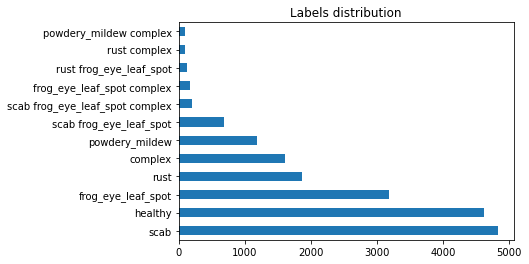

In [4]:
print(total_samples)
data_df.labels.value_counts().plot(kind = "barh")
plt.title('Labels distribution')
plt.show()

# Eliminate the duplicates

In [5]:
duplicates_df = pd.read_csv("../input/50-duplicates/duplicates (1).csv")
duplicates_df.head()

,image1,image2,label1,label2,label
0,e83f715e56462a31.jpg,d0c766bc38e1978c.jpg,rust,complex,complex
1,a3bb604d8a55995d.jpg,e7ecc583d571d202.jpg,complex,rust,complex
2,e13be7f1105e8f80.jpg,e11be7f110de8f80.jpg,rust,rust,rust
3,d2266ac99461e9db.jpg,c1753cad2f31d492.jpg,rust complex,rust,rust complex
4,d89c9cda9274322f.jpg,d89d9ede82743229.jpg,rust,rust,rust


# Remove duplicate and change the labels

In [6]:
duplicates = duplicates_df.image1.values
for dup in duplicates:
    data_df.drop(data_df.loc[data_df['image'] == dup].index, inplace=True)
    
dups = duplicates_df.image2.values
dups_labels = duplicates_df.label.values
for dup, label in zip(dups, dups_labels):
    data_df.loc[data_df['image'] == dup , 'labels' ] = label

# Labels - processing

In [7]:
unique_labels = []
for label in data_df.labels.unique():
    for labels in label.split(" "):
        if labels not in unique_labels:
            unique_labels.append(labels)
unique_labels
    

['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew']

In [8]:
def process_label(data_df):
    data = data_df.copy()
    for label in unique_labels:
        data[label] = data["labels"].apply(lambda x : 1 if label in x else 0)
    return data[unique_labels]

In [9]:
data_labels = process_label(data_df)
data_labels

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
18627,1,0,0,0,0,0
18628,0,1,0,0,0,0
18629,0,0,0,0,1,0
18630,0,1,1,0,0,0


# Data visualization

In [10]:
def visualize_random_images(resize = False):
    random_idxs = np.random.randint(len(data_df),size = 9)
    random_imgs = data_df.image.iloc[random_idxs].values

    fig, axes = plt.subplots(3, 3, figsize = (14, 10))
    for i in range(9):
        imgPath = IMG_DIR + random_imgs[i]
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if resize:
            img = cv2.resize(img, (512, 512))
        axes[i//3][i % 3].imshow(img)
    plt.show()

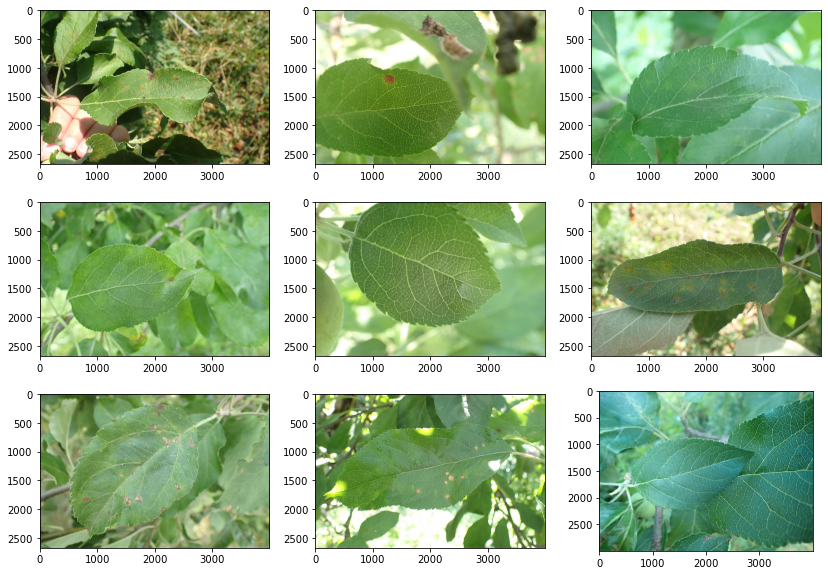

In [11]:
visualize_random_images()

### Images are high-res, to feed them to classifier model, we need to resize them ( in this case, make them smaller)

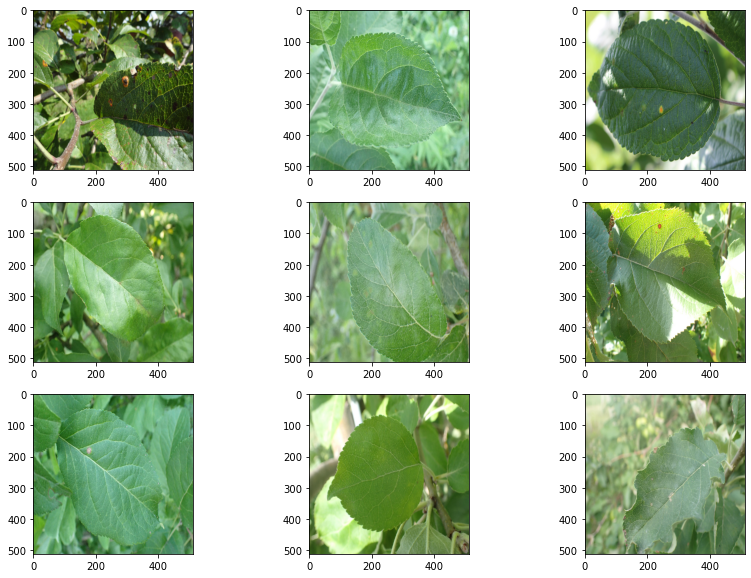

In [12]:
visualize_random_images(resize = True)

# Data splitting

In [13]:
# adding the full path to the images
data_df.image = IMG_DIR + data_df.image
# shuffle
data_df = data_df.sample(frac = 1)
#random 80-20 split
train_df, val_df = train_test_split(data_df, test_size = 0.2)

# Get the labels

In [14]:
train_labels, val_labels = process_label(train_df), process_label(val_df)
train_labels.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
11878,0,1,0,0,0,0
6592,1,0,0,0,0,0
7050,1,0,0,0,0,0
15939,1,0,0,0,0,0
3317,0,0,0,1,0,1


In [15]:
train_labels = np.array(train_labels, dtype = np.float32)
val_labels  =  np.array(val_labels, dtype = np.float32)
print("Train: ", train_labels.shape)
print("Val: ", val_labels.shape)

Train:  (14865, 6)
Val:  (3717, 6)


# Construct the dataset

In [16]:
import random
# defined an cutout function for images
def cutout(image, num_holes = 40, hole_size = 10):
    img = np.array(image)
    img_height, img_width = img.shape[:-1]
    
    for i in range(num_holes):    
        x = random.randint(0,img_height-hole_size)
        y = random.randint(0,img_width-hole_size)
        img[x:x+hole_size , y:y+hole_size,:] = 0 
    return img

In [17]:
def process_image_and_labels(image_path, labels = None):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method = "nearest")
    img = tf.numpy_function(cutout, [img], tf.uint8)
    if labels is not None:
        return img, labels
    return img

In [18]:
train_dataset = (
    tf.data.Dataset.
        from_tensor_slices((train_df.image, train_labels)).
        map(process_image_and_labels, num_parallel_calls=AUTOTUNE).
        shuffle(buffer_size=1000).
        batch(BATCH_SIZE).
        prefetch(buffer_size=AUTOTUNE)

)

val_dataset = (
    tf.data.Dataset.
            from_tensor_slices((val_df.image, val_labels)).
            map(process_image_and_labels, num_parallel_calls=AUTOTUNE).
            shuffle(buffer_size=1000).
            batch(BATCH_SIZE).
            prefetch(buffer_size=AUTOTUNE)
)

# Load Pretrained Model -> EfficientNetB0

In [19]:
#conv_base = tf.keras.models.load_model("../input/efficientnetb0weights/EfficientNetB0-weights.h5")
conv_base = EfficientNetB3(include_top = False, weights = 'imagenet',
                           input_shape = (IMG_SIZE, IMG_SIZE, 3), pooling ='avg', drop_connect_rate=0.4)

43941888/43941136 [==============================] - 1s 0us/step


# Data augmentation

In [20]:

data_augmentation = tf.keras.Sequential([
         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
         layers.experimental.preprocessing.RandomRotation(0.1),
         layers.experimental.preprocessing.RandomContrast(0.1),
         layers.experimental.preprocessing.RandomZoom(0.1),
         #layers.experimental.preprocessing.RandomTranslation(height_factor = (-0.1, 0.1), width_factor = (-0.1, 0.1),
         #                                                  fill_mode="nearest", interpolation="nearest")
         ],
    name = "augmentation")
plt.show()

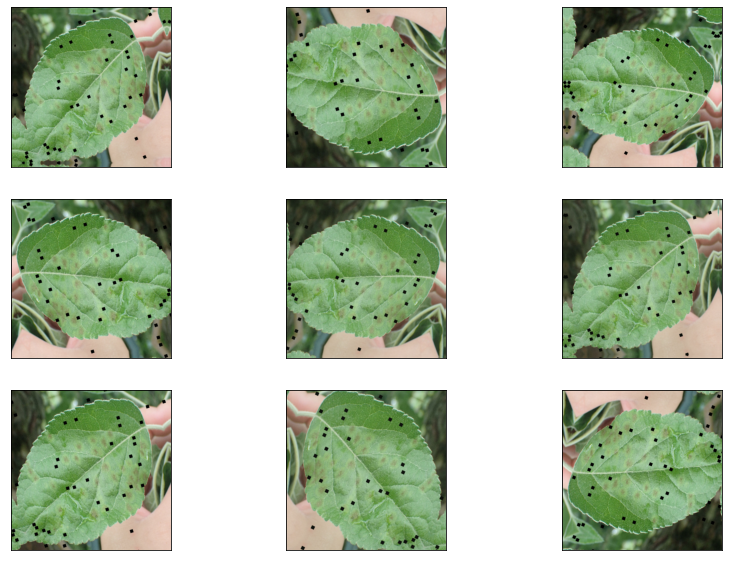

In [21]:
img = process_image_and_labels("../input/plant-pathology-2021-fgvc8/train_images/80070f7fb5e2ccaa.jpg")
img = tf.expand_dims(img, 0)
plt.figure(figsize = (14, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = data_augmentation(img)
    fig = plt.imshow(aug_img[0])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()
    


## Custom Loss : [Taylor Loss](https://www.ijcai.org/Proceedings/2020/0305.pdf)

In [22]:
def taylor_loss(y_true, y_pred):
      tf.dtypes.cast(y_true, tf.float32)
      tf.dtypes.cast(y_pred, tf.float32)
      ft = tf.keras.losses.mean_absolute_error(y_true, y_pred)
      st = tf.keras.backend.mean(tf.math.pow(y_true - y_pred, 2), axis=-1)
      tt = tf.keras.backend.mean(tf.math.pow(y_true - y_pred, 3), axis=-1)
      #lt = tf.keras.backend.mean(tf.math.pow(y_true - y_pred, 4), axis=-1)
      return (ft + st) / 2 + tt / 3 

# Define the classifier model

In [23]:
def create_classifier(conv_base):
    inputs = conv_base.input
    augmented_images = data_augmentation(inputs)
    feature_vectors = conv_base(augmented_images)
    dense = layers.Dense(128, activation = "relu")(feature_vectors)
    dropout = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(6, activation = "sigmoid")(dropout)
    model =  tf.keras.Model(inputs, outputs)
    #loss fn
    cce_loss =  tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.001)
    #optimizer
    cosine_decay = tf.keras.experimental.CosineDecay(initial_learning_rate = 1e-4, decay_steps = (total_samples // BATCH_SIZE) * EPOCHS )
    adam =  tf.keras.optimizers.Adam(cosine_decay)
    #metric
    f1_metric = tfa.metrics.F1Score(num_classes = 6, average = "macro")
    model.compile(loss = [taylor_loss, cce_loss], optimizer = adam, metrics = ["accuracy", f1_metric], loss_weights = [0.2, 0.8])
    return model

model = create_classifier(conv_base)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
augmentation (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 10,981,045
Trainable params: 10,893,742
Non-trainable params: 87,303
____________________________________________

# Training the model

Epoch 1/10
1859/1859 [==============================] - 1613s 834ms/step - loss: 0.0274 - accuracy: 0.6521 - f1_score: 0.5731 - val_loss: 0.0093 - val_accuracy: 0.8542 - val_f1_score: 0.8345
Epoch 2/10
1859/1859 [==============================] - 1597s 837ms/step - loss: 0.0112 - accuracy: 0.8391 - f1_score: 0.8119 - val_loss: 0.0079 - val_accuracy: 0.8609 - val_f1_score: 0.8508
Epoch 3/10
1859/1859 [==============================] - 1627s 853ms/step - loss: 0.0093 - accuracy: 0.8560 - f1_score: 0.8379 - val_loss: 0.0067 - val_accuracy: 0.8792 - val_f1_score: 0.8767
Epoch 4/10
1859/1859 [==============================] - 1617s 847ms/step - loss: 0.0084 - accuracy: 0.8664 - f1_score: 0.8470 - val_loss: 0.0068 - val_accuracy: 0.8746 - val_f1_score: 0.8654
Epoch 5/10
1859/1859 [==============================] - 1663s 871ms/step - loss: 0.0077 - accuracy: 0.8768 - f1_score: 0.8616 - val_loss: 0.0072 - val_accuracy: 0.8692 - val_f1_score: 0.8568
Epoch 6/10
1859/1859 [=======================

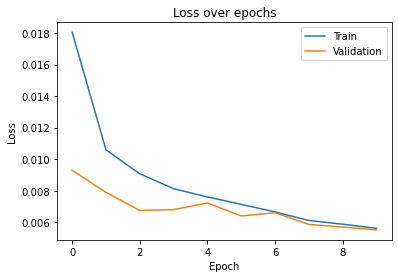

In [24]:
#callbacks
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
#fitting the model
history = model.fit(train_dataset,
                  epochs = EPOCHS, 
                  validation_data = val_dataset, 
                  callbacks = [early_stop])
  
#plot the loss and val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Saving the model

In [25]:
model.save("EffNetB0-PP2021_v1.h5")